In [28]:
from diffmain import *
from DataL import *
import glob
import sys
import os
import re
import torch    
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import pdb
from torch.utils.data import DataLoader
from torch.utils.data.distributed import DistributedSampler

In [29]:
def create_smaller_dataset(original_dataset, factor):
    # Calculate the size of the smaller dataset
    smaller_size = len(original_dataset) // factor

    # Randomly select indices for the smaller dataset
    smaller_indices = random.sample(range(len(original_dataset)), smaller_size)

    # Create the smaller dataset
    smaller_dataset = [original_dataset[i] for i in smaller_indices]

    return smaller_dataset

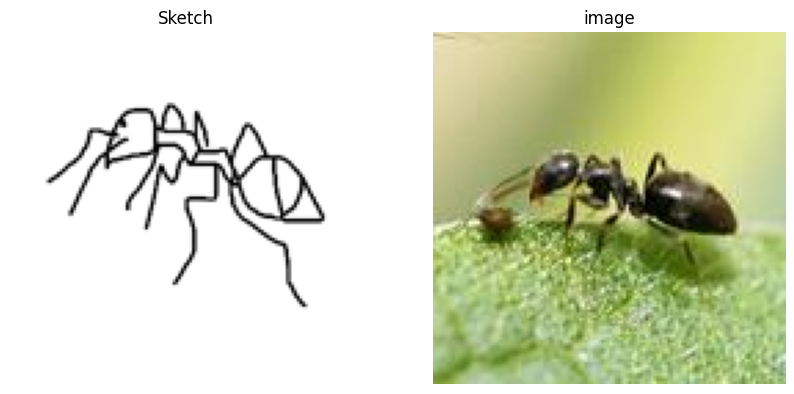

In [30]:

#photos_dir = '/Users/deniskaanalpay/Desktop/CMU/Term_2/18786_Intro_to_DL/SketchtoImage/rendered_256x256/256x256/photo/resized'
#sketches_dir = '/Users/deniskaanalpay/Desktop/CMU/Term_2/18786_Intro_to_DL/SketchtoImage/rendered_256x256/256x256/sketch/resized'

base_dir = os.getcwd()
photos_dir = os.path.join(base_dir, 'rendered_256x256/256x256/photo/resized/ant')
sketches_dir = os.path.join(base_dir, 'rendered_256x256/256x256/sketch/resized/ant')

transform = transforms.Compose([transforms.ToTensor()]) 
SketchySet = SketchyData(sketches_dir, photos_dir, transform=transform)
#torch.utils.data.DataLoader(SketchySet, batch_size=256)


i=random.randint(0,len(SketchySet)-1)
sk,im = SketchySet[i]

# Convert the tensors back to numpy arrays
sk = sk.numpy()
im = im.numpy()

sk=np.array(sk).transpose((1,2,0))
im=np.array(im).transpose((1,2,0))
#print(im)
fig, ax = plt.subplots(1,2,figsize=(10,5))
ax[0].imshow(sk)
ax[0].set_title('Sketch')
ax[0].axis('off')

ax[1].imshow(im)
ax[1].set_title('image')
ax[1].axis('off')

plt.show()



In [31]:
diffusion_steps = 1000
architecture = "UNet"
sampling_steps = 250
DDIM = False
local_rank = 0
seed = 112233
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
device = "cuda:{}".format(local_rank)
torch.cuda.set_device(device)
torch.manual_seed(seed + local_rank)
np.random.seed(seed + local_rank)
batch_size = 2


cuda


In [35]:
model = unets.__dict__[architecture](
    image_size=128,
    in_channels=3,
    out_channels=3).to(device)


diffusion = GuassianDiffusion(diffusion_steps, device = device)

lr = 0.001
optimizer = torch.optim.AdamW(model.parameters(), lr= 0.001)
ngpus = torch.cuda.device_count()
if ngpus > 1:
    if local_rank == 0:
        print(f"Using distributed training on {ngpus} gpus.")
    batch_size = batch_size // ngpus
    torch.distributed.init_process_group(backend="nccl", init_method="env://")
    model = DDP(model, device_ids=[local_rank], output_device=local_rank)

train_set=create_smaller_dataset(get_miniset(), factor=50)
sampler = DistributedSampler(train_set) if ngpus > 1 else None
train_loader = DataLoader(train_set, batch_size=batch_size, sampler=sampler, num_workers=1, pin_memory=True)
if local_rank == 0:
    print(
        f"Training dataset loaded: Number of batches: {len(train_loader)}, Number of images: {len(train_set)}"
    )

Training dataset loaded: Number of batches: 6, Number of images: 11


In [36]:
epochs = 10
optimizer = optim.AdamW(model.parameters(), lr=lr)
model.train()
Tloss = []
for epoch in range(epochs):
    totalloss=0
    #train_one_epoch(model, train_loader, optimizer, device, epoch, diffusion)
    for step, (photo, sketch) in enumerate(train_loader):
        assert (photo.max().item() <= 1) and (0 <= photo.min().item())
        photo = photo.to(device)
        sketch = sketch.to(device)
        photo, sketch = (2 * photo - 1, sketch)

        t = torch.randint(diffusion.timesteps, (len(photo),), dtype=torch.int64).to(device)
        
        xt, eps = diffusion.sample_from_forward_process(photo, t)
        pred_eps = model(xt, t, y = None)

        loss = ((pred_eps - eps) ** 2).mean()
        loss=loss/4
        totalloss+=loss.item()
        loss.backward()
        if step%4 == 0:
            optimizer.step()
            optimizer.zero_grad()  

    totalloss=totalloss/len(dataloader)
    Tloss.append(totalloss)
    print("Epoch: ", epoch)
    print("Loss: ", loss.item())

Epoch:  0
Loss:  0.209803506731987
Epoch:  1
Loss:  0.19784319400787354
Epoch:  2
Loss:  0.13389623165130615
Epoch:  3
Loss:  0.1062365397810936
Epoch:  4
Loss:  0.0743577778339386
Epoch:  5
Loss:  0.1848694086074829
Epoch:  6
Loss:  0.04273269698023796
Epoch:  7
Loss:  0.04099992662668228
Epoch:  8
Loss:  0.02796408161520958
Epoch:  9
Loss:  0.014388002455234528


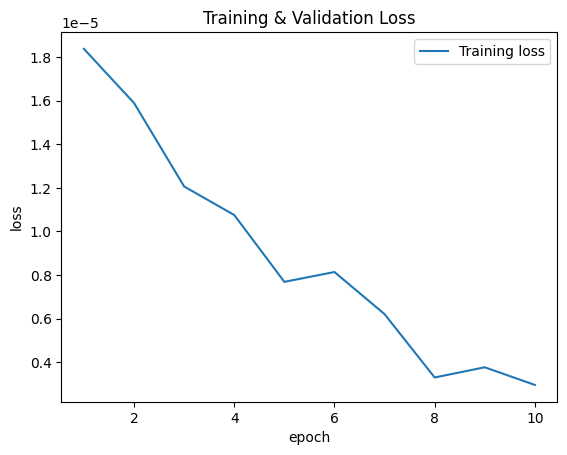

In [37]:
plt.plot(range(1,len(Tloss)+1), Tloss, label='Training loss')
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("Training & Validation Loss")
plt.legend()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


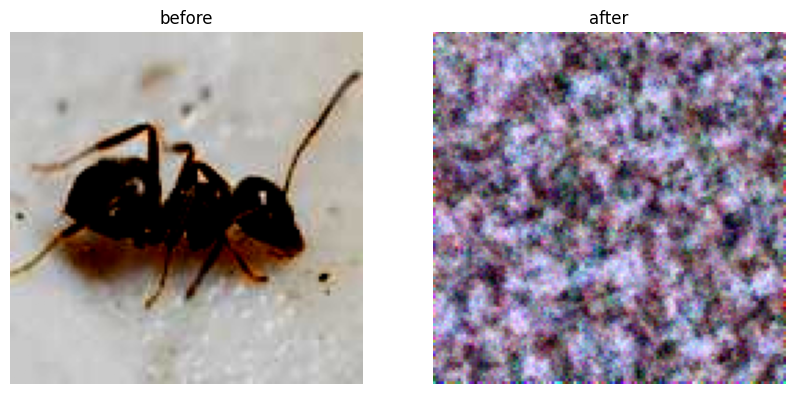

In [39]:
for step, (images, labels) in enumerate(train_loader):
    images, labels = (
        2 * images.to(device) - 1,
        labels,
    )
    model.eval()
    #pdb.set_trace()
    t = torch.randint(diffusion.timesteps, (len(images),), dtype=torch.int64).to(
        device
    )
    
    xt, eps = diffusion.sample_from_forward_process(images, t) #diffusion.timesteps - 1)
    pred_eps = model(xt, t, y=None)
    #pdb.set_trace()
    pred_eps=diffusion.sample_from_reverse_process(model, xt, diffusion.timesteps)
    #pdb.set_trace()
    pred_eps=(pred_eps.to(device) + 1) / 2

    fig, ax = plt.subplots(1,2,figsize=(10,5))
    ax[0].imshow(images[0].cpu().permute(1, 2, 0).detach().numpy())
    ax[0].set_title('before')
    ax[0].axis('off')

    ax[1].imshow(pred_eps[0].cpu().permute(1, 2, 0).detach().numpy())
    ax[1].set_title('after')
    ax[1].axis('off')
    plt.show()

    if step==0:
        break

In [ ]:
torch.save(model.state_dict(), 'model.pth')